In [20]:
#use this block of code to load helper functions from one directory up
def load_src(name, fpath):
    import os, imp
    return imp.load_source(name, os.path.join(os.path.dirname('__file__'), fpath))

load_src("QPP_Funcs", "../QPP_Funcs.py")

import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce
import os
from celerite.solver import LinAlgError
import dynesty
from dynesty import utils as dyfunc

SHO_prior_bounds  = [(np.log(1), np.log(1e7)),(np.log(2), np.log(20)), (2, 7)]
CTSModel_prior_bounds  = [(np.log(1), np.log(1e7)), (np.log(1), np.log(1e4)), (np.log(1), np.log(1e7)), (-10, 10)]
RealTerm_prior_bounds  = [(-20,20), (-20,10)]

bound_vec = SHO_prior_bounds  + CTSModel_prior_bounds
bound_vec2 = RealTerm_prior_bounds + CTSModel_prior_bounds
prior_transform = qpp.make_prior_transform(bound_vec)
prior_transform2 = qpp.make_prior_transform(bound_vec2)

dim = 5
s0 = np.linspace(np.log(2), np.log(9e6),dim)
q = np.linspace(np.log(3), np.log(19),dim)
a = np.linspace(-19.9,19.0,dim)
c= np.linspace(-19.9,9.9,dim)

datadir = "../Data/Simulating/09052018/"
loc = (datadir + "simulated_burst_")

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce

import glob, ast

files =  glob.glob(datadir+"*")
dim = int(np.sqrt(len(files)))
qpoparam_array = []
bfac_array = []
oparam_array = []
chain_array = []
I_array = []



print("Sorting Data...")

for i in range(len(files)):
    loc = files[i]+'/data'
    head, t, I, oparams, chain, res = qpp.load_flare(loc)
    p1 = head.partition('QPO Params: \t')
    p2 = p1[2].partition('\n')
    qpoparams = ast.literal_eval(p2[0])
    p3 = head.partition('Bayes Factor: \t')
    p4 = p3[2].partition('\n')
    bfac = ast.literal_eval(p4[0])
    chain = np.array(chain) 
    bfac_array.append(bfac[0])
    oparam_array.append(oparams)
    qpoparam_array.append(qpoparams)
    chain_array.append(chain)
    I_array.append(I)

t = np.linspace(0,4000,2000)
oparam_array = np.array(oparam_array)
bfac_array = np.array(bfac_array)
qpoparam_array = np.array(qpoparam_array)
chain_array = np.array(chain_array)
I_array = np.array(I_array)
    
oparams_grid = [[None for _ in range(dim)] for _ in range(dim)]
bfac_grid = [[None for _ in range(dim)] for _ in range(dim)]
qpoparams_grid = [[None for _ in range(dim)] for _ in range(dim)]
chain_grid = [[None for _ in range(dim)] for _ in range(dim)]
I_grid = [[None for _ in range(dim)] for _ in range(dim)]
    
sort_array = np.argsort(qpoparam_array, axis=0)
for i in range(len(sort_array)):
    oparams_grid[i/dim][i%dim] = oparam_array[sort_array[i][0]]
    bfac_grid[i/dim][i%dim] = bfac_array[sort_array[i][0]]
    qpoparams_grid[i/dim][i%dim] = qpoparam_array[sort_array[i][0]]
    chain_grid[i/dim][i%dim] = chain_array[sort_array[i][0]]
    I_grid[i/dim][i%dim] = I_array[sort_array[i][0]]


qpoparams = [1, 1, 3]
realparams = [-.13, -1.4] 
modelparams = [11.33844804, 6.92311406, 6.85207764, np.log(1000)]
model = qpp.CTSModel_prior(log_A = modelparams[0], log_tau1 = modelparams[1], log_tau2 = modelparams[2], log_bkg = modelparams[3])
kernel1 = qpp.SHOTerm_Prior(log_S0 = qpoparams[0], log_Q = qpoparams[1], log_omega0 = qpoparams[2])
#kernel2 = qpp.RealTerm_Prior(log_a = realparams[0], log_c = realparams[1])
kernel = kernel1
gp = ce.GP(kernel, mean=model, fit_mean=True)
print gp.get_parameter_names()

Sorting Data...
('kernel:log_S0', 'kernel:log_Q', 'kernel:log_omega0', 'mean:log_A', 'mean:log_tau1', 'mean:log_tau2', 'mean:log_bkg')


Plotting results...


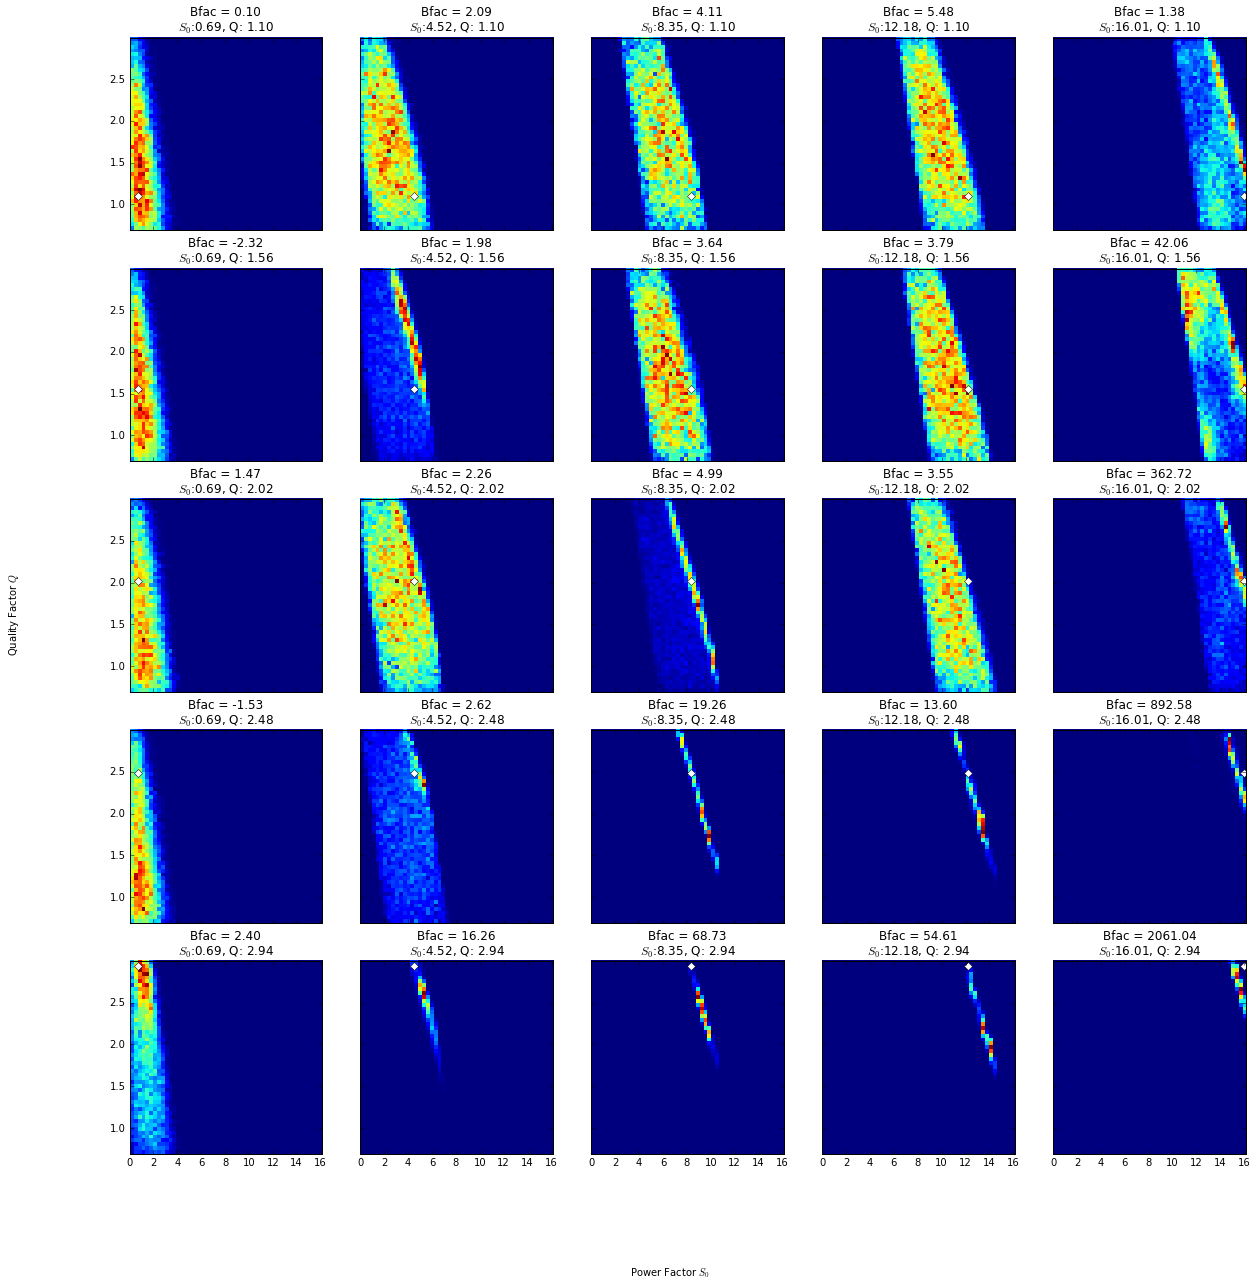

In [100]:
gridfig, gridax = plt.subplots(nrows = dim, ncols = dim, sharex=True, sharey=True, squeeze=True, figsize=(20,20))
#curvefig, curveax = plt.subplots(nrows = dim, ncols = dim, figsize=(20,20))

gridfig.text(0.5, 0.04, 'Power Factor $S_0$', ha='center')
gridfig.text(0.04, 0.5, 'Quality Factor $Q$', va='center', rotation='vertical')

print("Plotting results...")
sort_array = np.argsort(qpoparams_grid, axis=1)
for i in range(dim):
    for j in range(dim):
        index = sort_array[i][j][1]
        chain = chain_grid[i][index]
        bfac = bfac_grid[i][index]
        I = I_grid[i][index]
        oparams = oparams_grid[i][index]
        params = qpoparams_grid[i][index]
        s0_chain = chain[:,0]
        Q_chain = chain[:,1]
        bounds = [[SHO_prior_bounds[0][0],SHO_prior_bounds[0][1]],[SHO_prior_bounds[1][0], SHO_prior_bounds[1][1]]]
        gridax[j,i].hist2d(s0_chain, Q_chain,bins=50, range = bounds, normed=True)
        gridax[j,i].plot(params[0], params[1], 'wD')
        name = "Bfac = {0:.2f}".format(bfac) + "\n$S_0$:{0:.2f}".format(params[0])+", Q: {0:.2f}".format(params[1])
        gridax[j,i].set_title(name)
        gp.compute(t, np.sqrt(I))      
        curveax[j,i].set_title(name)
        
plt.show()

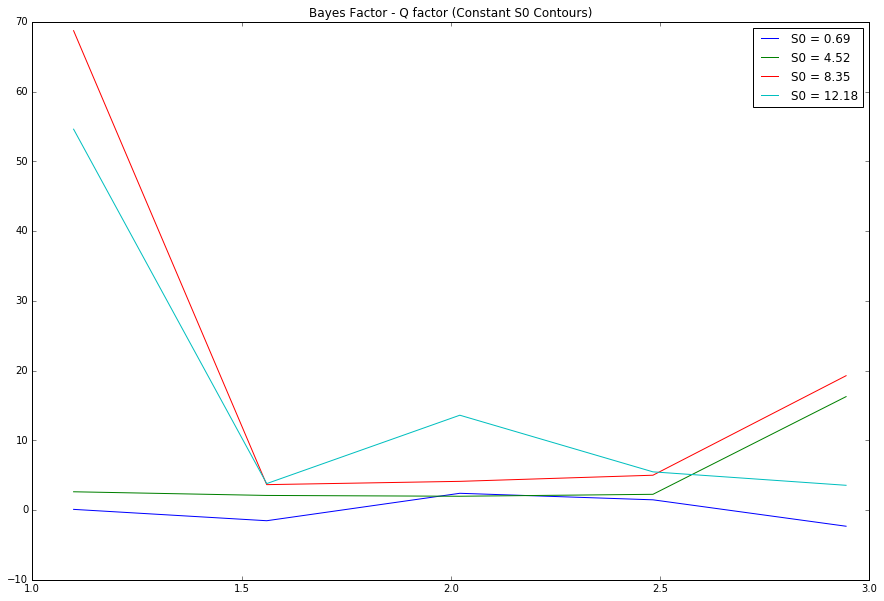

In [108]:
plt.figure(figsize=(15,10))
s0_sorted_short = []
qs_sorted = []
bfacs_sorted = []
for i in range(dim-1):
    index = sort_array[i][:][:,1]
    s0 = np.array(qpoparams_grid)[i][0,0]
    qs = np.array(qpoparams_grid)[i][:,1]
    bfacs = np.array([bfac_grid[i][j] for j in index])
    inds = qs.argsort()
    bfacs_sort = bfacs[inds]
    plt.plot(qs[inds], bfacs_sort, label = 'S0 = {:2.2f}'.format(s0))
    s0_sorted_short.append(s0)
    qs_sorted.append(qs[inds])
    bfacs_sorted.append(bfacs_sort)
plt.title("Bayes Factor - Q factor (Constant S0 Contours)")
plt.legend()
plt.show()

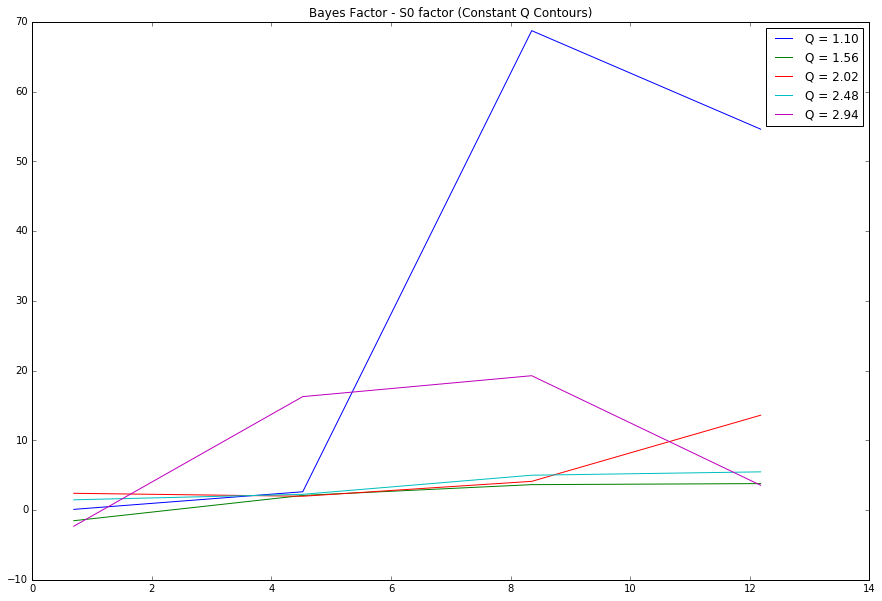

In [110]:
plt.figure(figsize=(15,10))
for i in range(dim):
    plt.plot(s0_sorted_short, np.array(bfacs_sorted)[:,i], label = 'Q = {:2.2f}'.format(np.array(qs_sorted)[0,i]))
plt.title("Bayes Factor - S0 factor (Constant Q Contours)")
plt.legend()
plt.show()

In [104]:
sort_array

array([[[0, 0, 0],
        [1, 3, 1],
        [2, 4, 2],
        [3, 2, 3],
        [4, 1, 4]],

       [[0, 3, 0],
        [1, 0, 1],
        [2, 1, 2],
        [3, 2, 3],
        [4, 4, 4]],

       [[0, 4, 0],
        [1, 1, 1],
        [2, 0, 2],
        [3, 2, 3],
        [4, 3, 4]],

       [[0, 4, 0],
        [1, 1, 1],
        [2, 3, 2],
        [3, 0, 3],
        [4, 2, 4]],

       [[0, 1, 0],
        [1, 4, 1],
        [2, 0, 2],
        [3, 2, 3],
        [4, 3, 4]]])